In [1]:
 pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
stock_data = yf.download('TSLA', start="2019-09-01", end="2023-11-15")

[*********************100%%**********************]  1 of 1 completed


In [4]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-03,14.938667,15.263333,14.877333,15.000667,15.000667,80311500
2019-09-04,15.126000,15.230667,14.614000,14.712000,14.712000,86415000
2019-09-05,14.833333,15.320000,14.723333,15.305333,15.305333,110929500
2019-09-06,15.146667,15.309333,15.011333,15.163333,15.163333,62841000
2019-09-09,15.333333,15.584000,15.282000,15.452667,15.452667,72040500
...,...,...,...,...,...,...
2023-11-08,223.149994,224.149994,217.639999,222.110001,222.110001,106584800
2023-11-09,219.750000,220.800003,206.679993,209.979996,209.979996,142110500
2023-11-10,210.029999,215.380005,205.690002,214.649994,214.649994,130994000


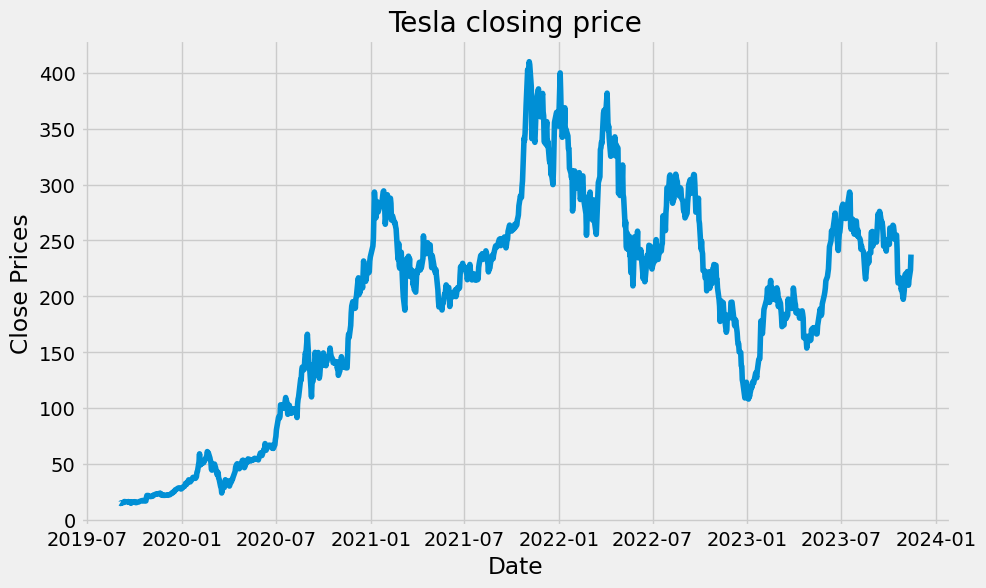

In [5]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Tesla closing price')
plt.show()

<Axes: ylabel='Density'>

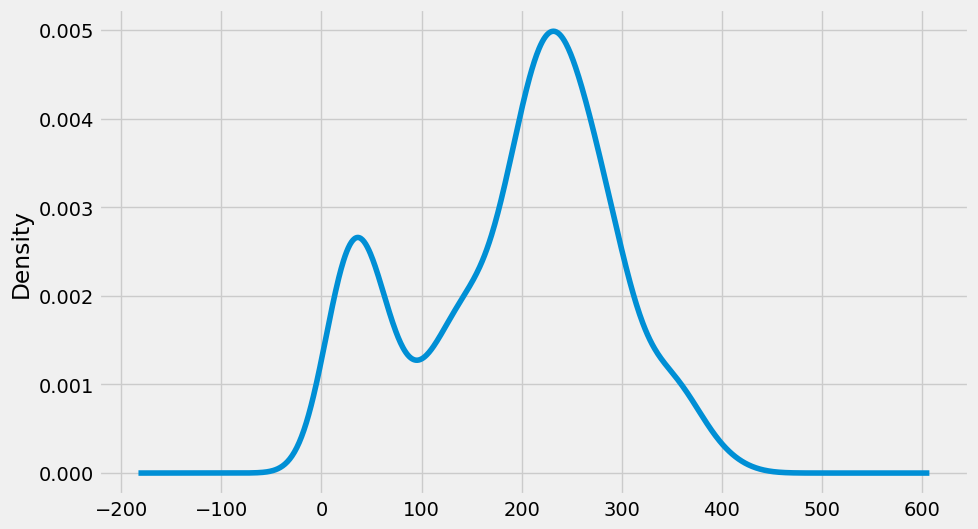

In [6]:
stock_data['Close'].plot(kind='kde')

In [7]:
df_close = stock_data['Close']

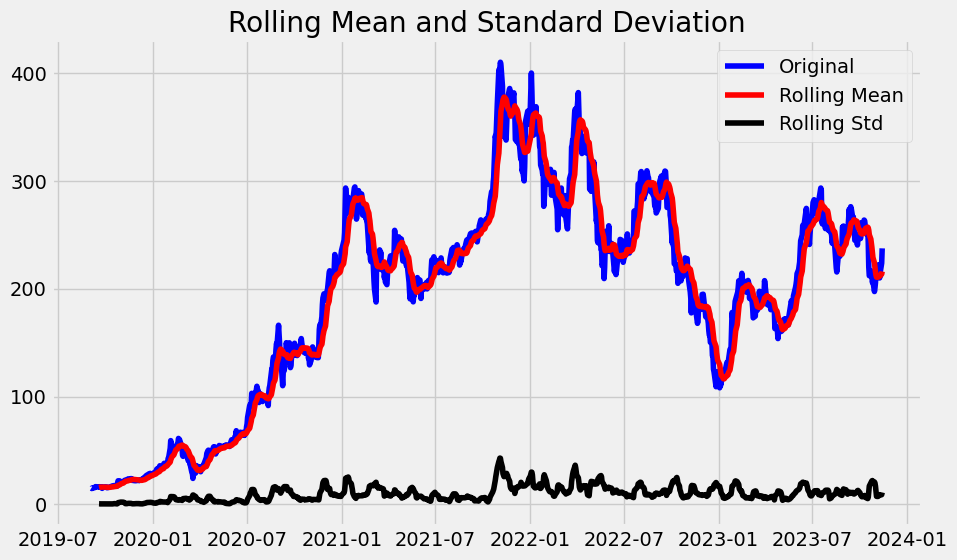

Results of dickey fuller test
Test Statistics                  -2.103106
p-value                           0.243267
No. of lags used                  9.000000
Number of observations used    1049.000000
critical value (1%)              -3.436599
critical value (5%)              -2.864299
critical value (10%)             -2.568239
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)



<Figure size 1000x600 with 0 Axes>

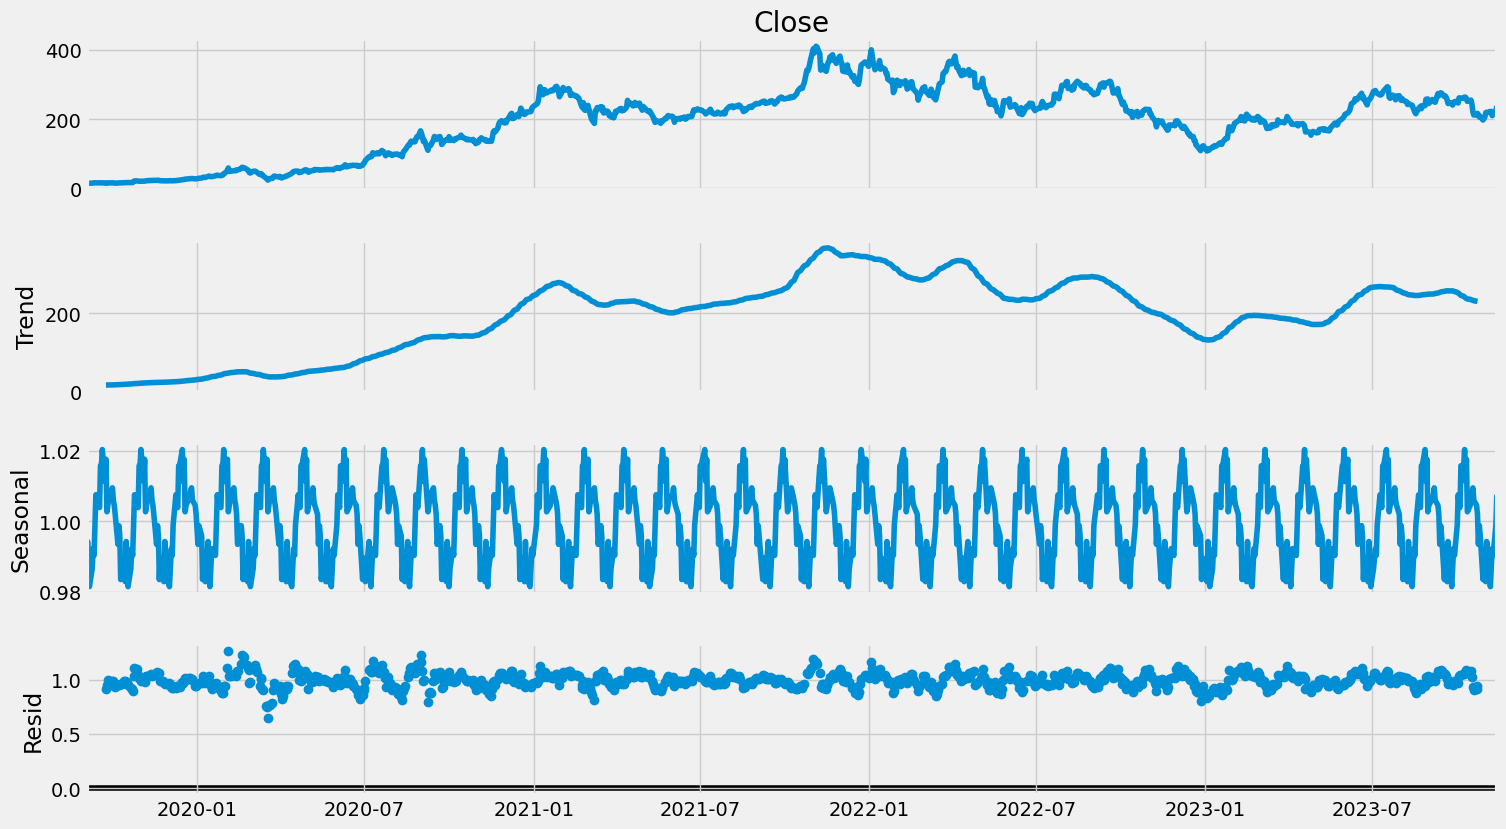

In [9]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period= 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

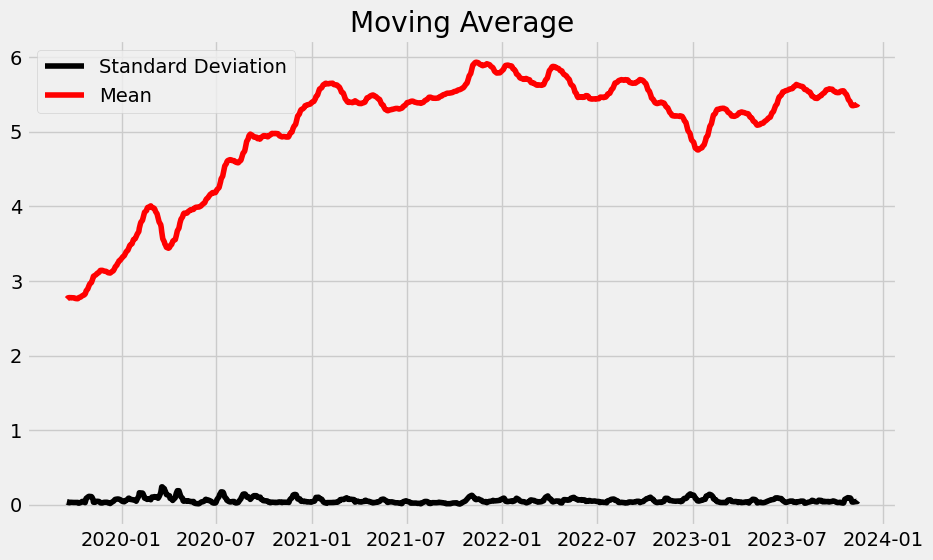

In [10]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

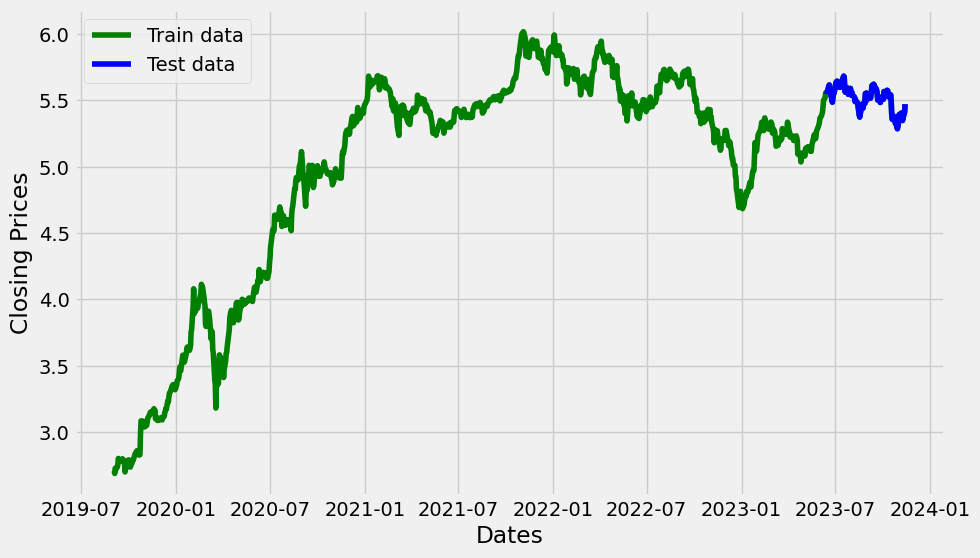

In [11]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3254.260, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3252.326, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3252.320, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3251.807, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3252.055, Time=0.55 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.022 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  950
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1629.130
Date:                Fri, 15 Dec 2023   AIC                          -3254.260
Time:                        18:24:56   BIC                          -3244.549
Sample:                             0   HQIC                         -3250.560
                                - 950                                  

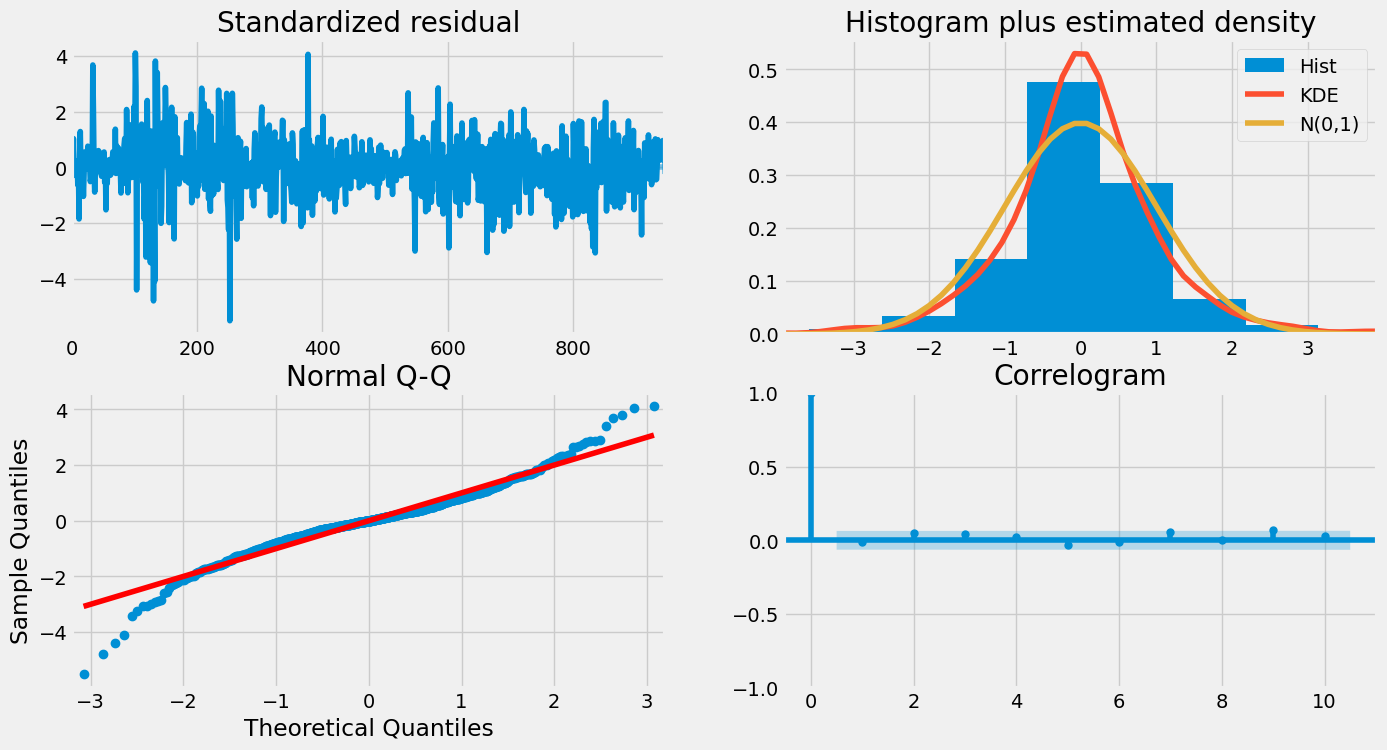

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [14]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  950
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1629.212
Date:                Fri, 15 Dec 2023   AIC                          -3250.423
Time:                        18:24:57   BIC                          -3231.001
Sample:                             0   HQIC                         -3243.023
                                - 950                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5525      0.290      1.902      0.057      -0.017       1.122
ma.L1         -0.5593      0.295     -1.897      0.058      -1.137       0.019
ma.L2          0.0620      0.030      2.058      0.0

In [15]:
forecast_result = fitted.get_forecast(steps=321, alpha=0.05)
fc = forecast_result.predicted_mean
se = forecast_result.se_mean
conf_int = forecast_result.conf_int(alpha=0.05)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [16]:
if conf_int.shape[1] != 2:
    raise ValueError("conf_int should have 2 columns")

In [17]:
conf_int = np.asarray(conf_int)

# Check the shapes and lengths
print("conf_int shape:", conf_int.shape)
print("test_data index length:", len(test_data.index))

conf_int shape: (321, 2)
test_data index length: 106


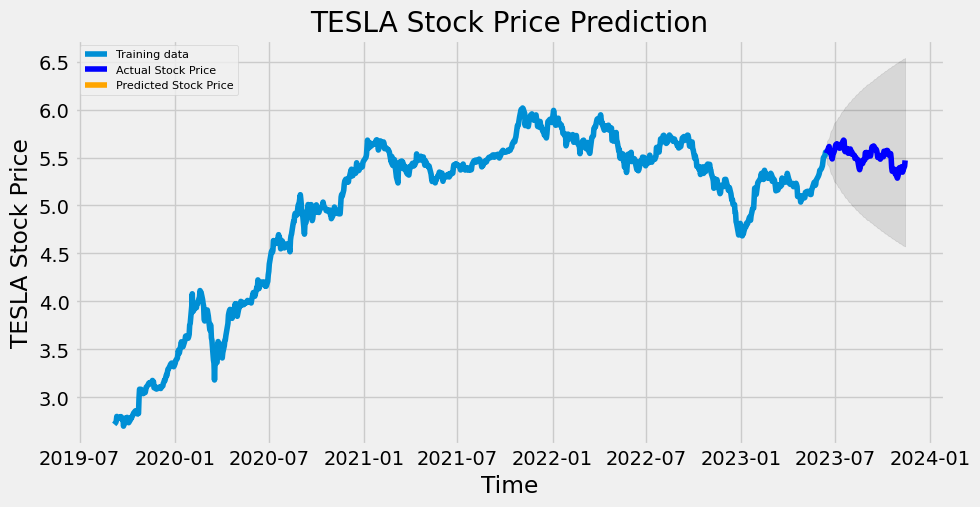

In [18]:
conf_int_subset = conf_int[:len(test_data.index), :]

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf_int_subset[:, 0], index=test_data.index)
upper_series = pd.Series(conf_int_subset[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(test_data.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
print("Predictions (fc):", fc[:10])


Predictions (fc): 950    5.552008
951    5.553420
952    5.554199
953    5.554630
954    5.554868
955    5.555000
956    5.555072
957    5.555112
958    5.555135
959    5.555147
Name: predicted_mean, dtype: float64


In [20]:
print("Index of fc_series:", fc_series.index[:10])


Index of fc_series: DatetimeIndex(['2023-06-15', '2023-06-16', '2023-06-20', '2023-06-21',
               '2023-06-22', '2023-06-23', '2023-06-26', '2023-06-27',
               '2023-06-28', '2023-06-29'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [21]:
print("Index of test_data:", test_data.index[:10])


Index of test_data: DatetimeIndex(['2023-06-15', '2023-06-16', '2023-06-20', '2023-06-21',
               '2023-06-22', '2023-06-23', '2023-06-26', '2023-06-27',
               '2023-06-28', '2023-06-29'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [22]:
print("NaN values in fc_series:", fc_series[fc_series.isna()])


NaN values in fc_series: Date
2023-06-15   NaN
2023-06-16   NaN
2023-06-20   NaN
2023-06-21   NaN
2023-06-22   NaN
              ..
2023-11-08   NaN
2023-11-09   NaN
2023-11-10   NaN
2023-11-13   NaN
2023-11-14   NaN
Name: predicted_mean, Length: 106, dtype: float64


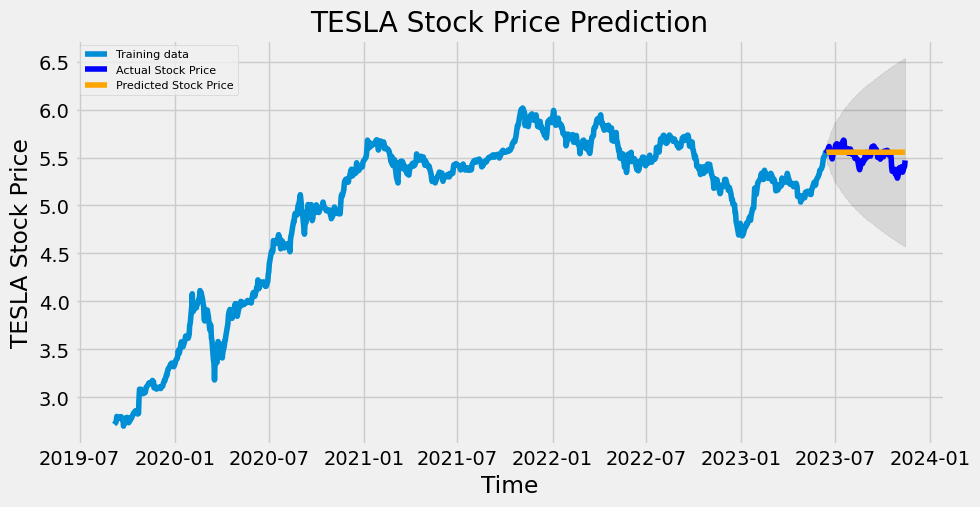

In [23]:
# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')

# Option 2: Plot a subset of fc that corresponds to the length of test_data.index
plt.plot(test_data.index, fc[:len(test_data.index)], color='orange', label='Predicted Stock Price')

plt.fill_between(test_data.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


Here are some additional specific observations that can be made about the graph:

* The ARIMA model appears to have captured the upward trend in Tesla's stock price over the past few years.
* The model has also captured some of the short-term fluctuations in the stock price.
* However, there are some periods where the predicted prices diverge significantly from the actual prices. For example, in the most recent time period, the model predicts that the stock price will continue to rise, while the actual price has fallen.

These discrepancies between the predicted and actual prices could be due to a number of factors, such as:

* The ARIMA model is not perfect, and there will always be some error in any prediction.
* The model may not be able to capture all of the factors that affect Tesla's stock price.
* The market is unpredictable, and there may be unforeseen events that cause the stock price to move in unexpected ways.

It is important to keep these limitations in mind when interpreting the results of the ARIMA model.

Overall, the conclusion you can draw from the graph is that the ARIMA model is a useful tool for predicting Tesla's stock price. However, it is important to remember that no model is perfect, and there will always be some degree of error in any prediction. It is also important to note that the past performance of a stock is not necessarily indicative of its future performance. Therefore, it is important to use this information as part of a larger investment strategy, and to consider other factors such as the company's financials, the overall market conditions, and your own risk tolerance before making any investment decisions.